#### **Imports**

In [407]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import time
import datetime
import tensorflow as tf

# Import from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
import category_encoders as ce
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix, multilabel_confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, plot_roc_curve, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

# Set a random seed
from numpy.random import seed

seed(8)
from tensorflow.random import set_seed
set_seed(8)

# Data Visualization
sns.set_theme(context='notebook', style='darkgrid', palette='viridis')

##### **Read in data with clusters**

In [434]:
df = pd.read_csv('../data/df_clusters.csv')
df.head()

,name,artist,track_id,instrumentalness,danceability,energy,liveness,loudness,acousticness,valence,speechiness,tempo,key,time_signature,length,popularity,mood,mood_map,cluster
0,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,0.000158,0.762,0.701,0.1230,-3.541,0.23500,0.742,0.0286,110.968,8,4,208866,92,Happy,2,0
1,seaside_demo,SEB,73M0rMVx5CWE8M4uATSsto,0.000133,0.706,0.824,0.1110,-7.959,0.35500,0.860,0.0694,94.980,0,4,132000,54,Happy,2,0
2,Shivers,Ed Sheeran,6bQfNiqyCX7UaQSvVVGo4I,0.000000,0.788,0.859,0.0424,-2.724,0.28100,0.822,0.0856,141.020,2,4,207853,78,Happy,2,0
3,Heat Waves,Glass Animals,02MWAaffLxlfxAUY7c5dvx,0.000007,0.761,0.525,0.0921,-6.900,0.44000,0.531,0.0944,80.870,11,4,238805,85,Happy,2,0
4,Electric Love,BØRNS,2GiJYvgVaD2HtM8GqD9EgQ,0.001370,0.611,0.797,0.2600,-7.627,0.00543,0.518,0.0533,120.041,6,4,218106,82,Happy,2,0


In [435]:
df.shape

(5849, 19)

In [436]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5849 entries, 0 to 5848
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5849 non-null   object 
 1   artist            5849 non-null   object 
 2   track_id          5849 non-null   object 
 3   instrumentalness  5849 non-null   float64
 4   danceability      5849 non-null   float64
 5   energy            5849 non-null   float64
 6   liveness          5849 non-null   float64
 7   loudness          5849 non-null   float64
 8   acousticness      5849 non-null   float64
 9   valence           5849 non-null   float64
 10  speechiness       5849 non-null   float64
 11  tempo             5849 non-null   float64
 12  key               5849 non-null   int64  
 13  time_signature    5849 non-null   int64  
 14  length            5849 non-null   int64  
 15  popularity        5849 non-null   int64  
 16  mood              5849 non-null   object 


In [437]:
features = df[['instrumentalness', 
               'danceability',
               'energy', 
               'liveness', 
               'loudness', 
               'acousticness', 
               'valence',
               'speechiness',
               'mood_map',
               'cluster']]

In [412]:
fig = px.scatter_matrix(features, width=1200, height=1600)
fig.write_html('../data_viz/first_figure.html', auto_open=True)

In [413]:
fig1 = px.scatter_matrix(features, color="mood_map")
fig1.update_layout(title="Features and Mood")
fig1.write_html('../data_viz/figure1.html', auto_open=True)

In [414]:
fig2 = px.scatter_3d(df, x="instrumentalness", y="mood_map", z='energy', color="mood_map")
fig2.update_layout(title="Instrumentalness & Energy")
fig2.write_html('../data_viz/figure2.html', auto_open=True)

#### **Null model:** 
###### Evaluate class imbalances
###### Classes are fairly balanced

In [438]:
df['mood'].value_counts(normalize=True)

Calm         0.283125
Energetic    0.247564
Sad          0.244315
Happy        0.224996
Name: mood, dtype: float64

In [439]:
df['cluster'].value_counts(normalize=True)

0    0.707471
1    0.292529
Name: cluster, dtype: float64

In [440]:
df['mood'].value_counts()

Calm         1656
Energetic    1448
Sad          1429
Happy        1316
Name: mood, dtype: int64

In [441]:
df.head()

,name,artist,track_id,instrumentalness,danceability,energy,liveness,loudness,acousticness,valence,speechiness,tempo,key,time_signature,length,popularity,mood,mood_map,cluster
0,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,0.000158,0.762,0.701,0.1230,-3.541,0.23500,0.742,0.0286,110.968,8,4,208866,92,Happy,2,0
1,seaside_demo,SEB,73M0rMVx5CWE8M4uATSsto,0.000133,0.706,0.824,0.1110,-7.959,0.35500,0.860,0.0694,94.980,0,4,132000,54,Happy,2,0
2,Shivers,Ed Sheeran,6bQfNiqyCX7UaQSvVVGo4I,0.000000,0.788,0.859,0.0424,-2.724,0.28100,0.822,0.0856,141.020,2,4,207853,78,Happy,2,0
3,Heat Waves,Glass Animals,02MWAaffLxlfxAUY7c5dvx,0.000007,0.761,0.525,0.0921,-6.900,0.44000,0.531,0.0944,80.870,11,4,238805,85,Happy,2,0
4,Electric Love,BØRNS,2GiJYvgVaD2HtM8GqD9EgQ,0.001370,0.611,0.797,0.2600,-7.627,0.00543,0.518,0.0533,120.041,6,4,218106,82,Happy,2,0


#### **Revevaluate KMeans Cluster with adjusted Mood Classes**

In [442]:
features = df[['instrumentalness', 
               'danceability',
               'energy', 
               'liveness', 
               'loudness', 
               'acousticness', 
               'valence',
               'speechiness']]

In [443]:
X = features
# standardize X data
xc = MinMaxScaler()
X_xc= xc.fit_transform(X)

scores = []
for k in range(2,31):
    cl = KMeans(n_clusters=k)
    cl.fit(X_xc)
    inertia = cl.inertia_
    sil = silhouette_score(X_xc, cl.labels_)
    scores.append([k, inertia, sil])
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']
score_df.head(10)

,k,inertia,silhouette
0,2,1477.327532,0.408663
1,3,1107.387196,0.376530
2,4,929.340718,0.288734
3,5,803.364064,0.296953
4,6,730.429209,0.276860
5,7,682.809027,0.265652
6,8,645.954706,0.254928
7,9,613.186933,0.249659
8,10,579.524192,0.238972
9,11,555.799654,0.220101


No handles with labels found to put in legend.


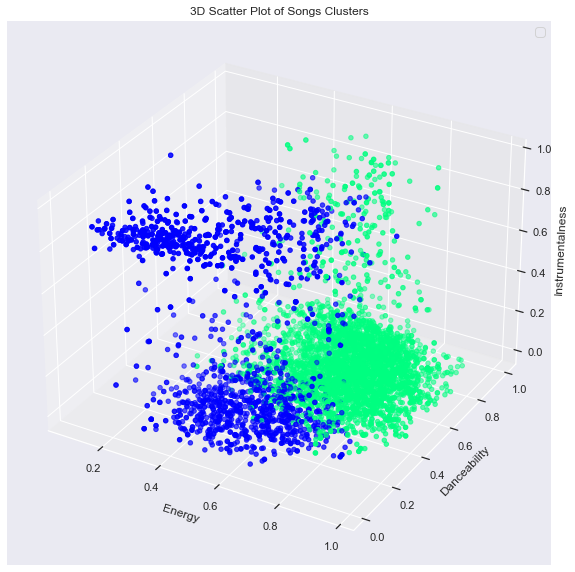

In [444]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(df['danceability'])
y = np.array(df['energy'])
z = np.array(df['valence'])
a = np.array(df['liveness'])
b = np.array(df['speechiness'])
e = np.array(df['acousticness'])
f = np.array(df['instrumentalness'])

ax.scatter(x,y,f,c=df['cluster'], s=20, cmap='winter_r')
ax.set_title("3D Scatter Plot of Songs Clusters")
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('Instrumentalness',fontsize=12)
ax.legend(fontsize=12, title_fontsize=12);

In [445]:
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10, tol=1e-04, random_state=42)
kmeans.fit(X_xc)
df['cluster']=pd.Series(kmeans.labels_)
# polar=clusters.groupby("cluster").mean().reset_index()
# polar=pd.melt(polar,id_vars=["cluster"])
# fig4 = px.line_polar(polar, r="value", theta="variable", color="cluster", line_close=True,height=800,width=1400)
# fig4.write_html('fig4.html', auto_open=True)

In [446]:
df[['cluster', 'mood']].groupby('mood')['cluster'].value_counts()

mood       cluster
Calm       0           882
           1           774
Energetic  1          1430
           0            18
Happy      1          1246
           0            70
Sad        0           850
           1           579
Name: cluster, dtype: int64

In [447]:
df['mood']=df['mood'].replace('Happy', 'Energetic')
df['mood_map'] = df['mood_map'].replace(3, 2)

In [448]:
df[['cluster', 'mood']].groupby('mood')['cluster'].value_counts()

mood       cluster
Calm       0           882
           1           774
Energetic  1          2676
           0            88
Sad        0           850
           1           579
Name: cluster, dtype: int64

In [449]:
X = features
# standardize X data
xc = MinMaxScaler()
X_xc= xc.fit_transform(X)

scores = []
for k in range(2,31):
    cl = KMeans(n_clusters=k)
    cl.fit(X_xc)
    inertia = cl.inertia_
    sil = silhouette_score(X_xc, cl.labels_)
    scores.append([k, inertia, sil])
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']
score_df.head(10)

,k,inertia,silhouette
0,2,1477.329927,0.408663
1,3,1107.380789,0.376431
2,4,929.339865,0.289548
3,5,803.365733,0.296977
4,6,730.429716,0.276818
5,7,682.812767,0.265274
6,8,645.014241,0.254569
7,9,611.410313,0.245285
8,10,580.549912,0.236805
9,11,555.740798,0.219767


In [456]:
kmeans = KMeans(n_clusters=3, init="k-means++", n_init=10, tol=1e-04, random_state=42)
kmeans.fit(X_xc)
df['cluster']=pd.Series(kmeans.labels_)
df[['cluster', 'mood']].groupby('mood')['cluster'].value_counts()

mood       cluster
Chill      2           654
           1           620
           0           382
Energetic  2          2551
           0           202
           1            11
Sad        0           879
           2           440
           1           110
Name: cluster, dtype: int64

In [457]:
df['mood'] = df['mood'].replace({'Calm': 'Chill'})

In [458]:
df.to_csv('../data/df_moodadj_cluster.csv', index=False)

In [459]:
df['mood'].value_counts(normalize=True)

Energetic    0.472559
Chill        0.283125
Sad          0.244315
Name: mood, dtype: float64